In [15]:
from pathlib import Path
import os
cwd_path = Path.cwd(); set_path = str(cwd_path.parent.parent); os.chdir(set_path)

In [16]:
import torch
import matplotlib.pyplot as plt
from TargetDistributions.Guassian_FullCov import Guassian_FullCov
from FittedModels.Models.DiagonalGaussian import DiagonalGaussian
from ImportanceSampling.AnnealedImportanceSampler import AnnealedImportanceSampler
from ImportanceSampling.VanillaImportanceSampler import VanillaImportanceSampling
from TargetDistributions.MoG import MoG
from FittedModels.Models.FlowModel import FlowModel

In [17]:
from Utils.plotting_utils import plot_func2D, plot_distribution
from Utils.numerical_utils import MC_estimate_true_expectation, expectation_function

## Setup Problem

In [43]:
torch.manual_seed(0)
n_samples = int(1e3)
dim = 3 # 2 for plotting, 5 to make more difficult but then plots make less sense
#************ EASY ******************
#target = Guassian_FullCov(dim=dim)
#learnt_sampler = DiagonalGaussian(dim=dim)

#************* HARD ************************
target = MoG(dim=dim, n_mixes=10, min_cov=0, loc_scaling=3)
learnt_sampler = FlowModel(x_dim=dim, n_flow_steps=3, scaling_factor=5.0)

#****************************************
true_expectation = MC_estimate_true_expectation(target, expectation_function, int(1e6))
print(true_expectation)
print(MC_estimate_true_expectation(target, expectation_function, int(1e6))) # should print 2 similar-ish numbers

tensor(20.3001)
tensor(20.2988)


## Annealed Importance Sampling 

In [44]:
AIS = AnnealedImportanceSampler(sampling_distribution=learnt_sampler, target_distribution=target,
                                                        distribution_spacing="geometric")

In [45]:
with torch.no_grad():
    expectation, info_dict = AIS.calculate_expectation(n_samples, expectation_function=expectation_function)
print(f"true expectation is {true_expectation}, estimated expectation is {expectation}")
print(f"ESS is {info_dict['effective_sample_size']/n_samples}, var is {torch.var(info_dict['normalised_sampling_weights'])}")

true expectation is 20.300125122070312, estimated expectation is 20.198532104492188
ESS is 0.4361277222633362, var is 1.2942006151206442e-06


### Plotting

Text(0.5, 1.0, 'true samples')

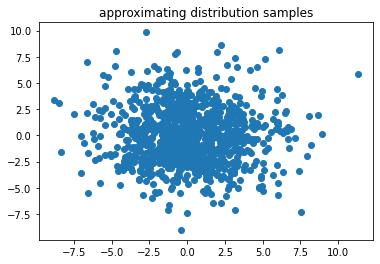

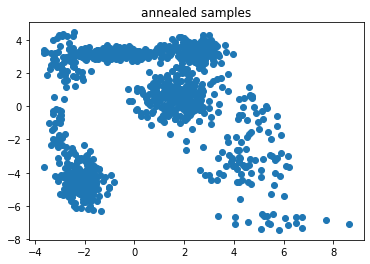

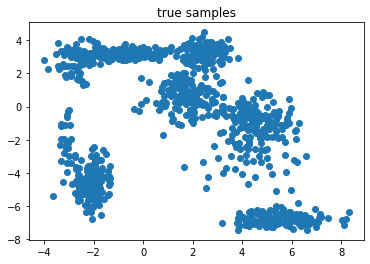

In [46]:
plt.figure()
learnt_dist_samples = learnt_sampler.sample((1000,)).detach()
plt.scatter(learnt_dist_samples[:, 0], learnt_dist_samples[:, 1])
plt.title("approximating distribution samples")
plt.figure()
plt.scatter(info_dict["samples"][:, 0], info_dict["samples"][:, 1])
plt.title("annealed samples")
plt.figure()
true_samples = target.sample((1000,)).detach()
plt.scatter(true_samples[:, 0], true_samples[:, 1])
plt.title("true samples")

### with linear spacing

In [47]:

AIS = AnnealedImportanceSampler(sampling_distribution=learnt_sampler, target_distribution=target,
                                                        distribution_spacing="linear")
with torch.no_grad():
    expectation, info_dict = AIS.calculate_expectation(1000, expectation_function=expectation_function)
print(true_expectation, expectation)
print(info_dict["effective_sample_size"], torch.var(info_dict['normalised_sampling_weights']))

tensor(20.3001) tensor(19.4827)
tensor(450.3303) tensor(1.2218e-06)


## Standard Importance Sampling

In [48]:
vanilla_IS = VanillaImportanceSampling(sampling_distribution=learnt_sampler, target_distribution=target)

In [49]:
with torch.no_grad():
    expectation, info_dict = AIS.calculate_expectation(n_samples, expectation_function=expectation_function)
print(f"true expectation is {true_expectation}, estimated expectation is {expectation_vanilla}")
print(f"ESS is {info_dict_vanilla['effective_sample_size']/n_samples}, \
      var is {torch.var(info_dict_vanilla['normalised_sampling_weights'])}")

true expectation is 20.300125122070312, estimated expectation is 26.260358810424805
ESS is 0.038699373602867126,       var is 2.486507764842827e-05


## Annealed Importance Sampling with more intermediate distributions
Improves ESS

In [50]:
AIS = AnnealedImportanceSampler(sampling_distribution=learnt_sampler, target_distribution=target,
                                                        distribution_spacing="geometric",
                                n_distributions=400, n_updates_Metropolis=20,)

In [51]:
with torch.no_grad():
    expectation, info_dict = AIS.calculate_expectation(n_samples, expectation_function=expectation_function)
print(f"true expectation is {true_expectation}, estimated expectation is {expectation}")
print(f"ESS is {info_dict['effective_sample_size']/n_samples}, var is {torch.var(info_dict['normalised_sampling_weights'])}")

true expectation is 20.300125122070312, estimated expectation is 20.516868591308594
ESS is 0.4721946120262146, var is 1.1188900543857017e-06


### with linear spacing

In [52]:

AIS = AnnealedImportanceSampler(sampling_distribution=learnt_sampler, target_distribution=target,
                                                        distribution_spacing="linear",
                                n_distributions=400, n_updates_Metropolis=20,)
with torch.no_grad():
    expectation, info_dict = AIS.calculate_expectation(n_samples, expectation_function=expectation_function)
print(f"true expectation is {true_expectation}, estimated expectation is {expectation}")
print(f"ESS is {info_dict['effective_sample_size']/n_samples}, var is {torch.var(info_dict['normalised_sampling_weights'])}")

true expectation is 20.300125122070312, estimated expectation is 20.671018600463867
ESS is 0.6142372488975525, var is 6.286639973041019e-07


Text(0.5, 1.0, 'true samples')

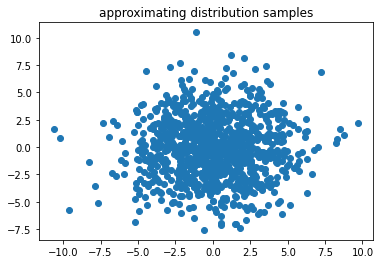

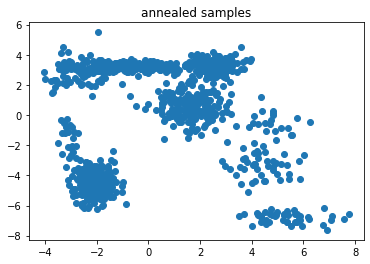

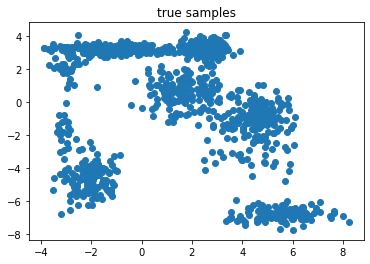

In [54]:
plt.figure()
learnt_dist_samples = learnt_sampler.sample((1000,)).detach()
plt.scatter(learnt_dist_samples[:, 0], learnt_dist_samples[:, 1])
plt.title("approximating distribution samples")
plt.figure()
plt.scatter(info_dict["samples"][:, 0], info_dict["samples"][:, 1])
plt.title("annealed samples")
plt.figure()
true_samples = target.sample((1000,)).detach()
plt.scatter(true_samples[:, 0], true_samples[:, 1])
plt.title("true samples")